### [Only In Google Colab] Setup TiRex in Colab

Make sure that you selected a **GPU runtime in Google Colab**
Runtime ->  Change Runtime Type -> Select A100 / L4 / T4

In [7]:
# Only for Google Colab Notebook!

import os

# Clone TiRep Repo
!git clone https://github.com/NX-AI/tirex

# Install TiRex
os.chdir('/content/tirex')
!pip install .[gluonts]

# Set Workin Dir to notebooks folder
os.chdir('/content/tirex/examples')

Cloning into 'tirex'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 10), reused 49 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 54.81 KiB | 5.48 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Processing /content/tirex
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tirex: filename=tirex-1.0.0-py3-none-any.whl size=25446 sha256=ee8c62e10f2cdfa317e2cac87eddb2f078f75cc394758ef04e4635786c37af6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7foy65en/wheels/a0/88/0b/ecc48e9efcb64e525bcc159d1e7b48fba6ad9bfc6b1a8f6258
Successfully built tirex
  Attempting uninstall: tirex
    Found existing installation: tirex 1.0.0
    Uninstalling tirex-1.0.0:
      Successfully uninstalled tirex-1.0.0


### Imports and Load Data

In [8]:
from pathlib import Path

import numpy as np
import torch
from util_plot import plot_fc

# import os
# os.environ["TIREX_NO_CUDA"] = "1"   # Experimental!!: Turns off sLSTM CUDA kernels if you have problems but be aware of the downsides! (see repository FAQ)
from tirex import ForecastModel, load_model

# Load Example Data
ctx_s, future_s = np.split(np.genfromtxt(Path.cwd() / "air_passengers.csv"), [-12])
ctx_l, future_l = np.split(np.genfromtxt(Path.cwd() / "loop_seattle_5T_example.csv"), [-512])

### TiRex Forecast in 2 Lines

1) Load Model
2) Generate Forecast

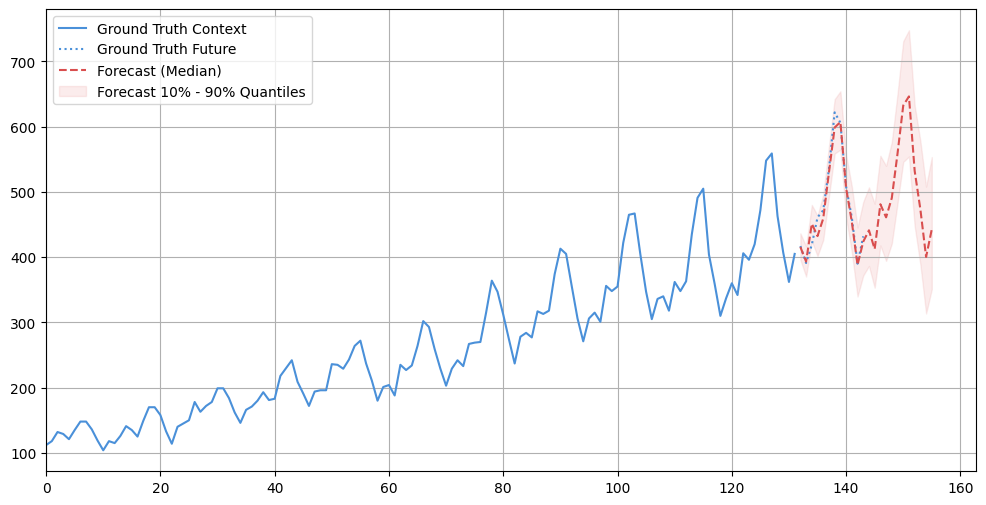

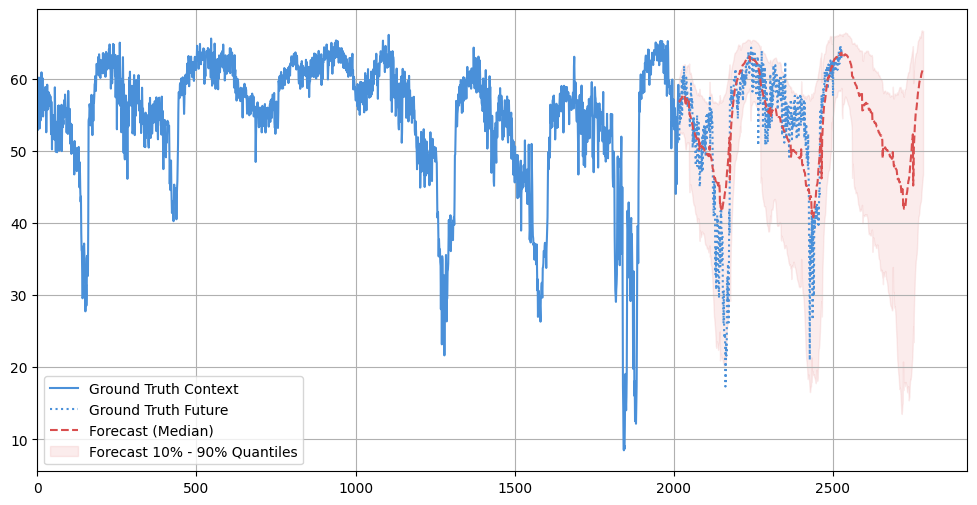

In [9]:
# 1) Load Model
model: ForecastModel = load_model("NX-AI/TiRex")

# 2) Short Horizon - Example
quantiles, mean = model.forecast(ctx_s, prediction_length=24)
plot_fc(ctx_s, quantiles[0], future_s)

# 2) Long Horizon - Example
quantiles, mean = model.forecast(ctx_l, prediction_length=768)
plot_fc(ctx_l, quantiles[0], future_l)

### Input Options

TiRex supports forecasting with different input types

In [10]:
data = torch.tensor(np.genfromtxt(Path.cwd() / "air_passengers.csv"))  # Load Example

# Torch tensor (2D or 1D)
quantiles, means = model.forecast(context=data, prediction_length=24)
print("Predictions (Torch tensor):\n", type(quantiles), quantiles.shape)

# List of Torch tensors (List of 1D) - will be padded
list_torch_data = [data, data, data]
quantiles, means = model.forecast(context=list_torch_data, prediction_length=24, batch_size=2)
print("Predictions (List of Torch tensors):\n", type(quantiles), quantiles.shape)

# NumPy array (2D or 1D)
quantiles, means = model.forecast(context=data.numpy(), prediction_length=24, output_type="torch")
print("Predictions (NumPy):\n", type(quantiles), quantiles.shape)


# List of NumPy arrays (List of 1D) - will be padded
list_numpy_data = [data.numpy()]  # Split into 3 sequences
quantiles, means = model.forecast(context=list_numpy_data, prediction_length=24)
print("Predictions (List of NumPy arrays):\n", type(quantiles), quantiles.shape)


# GluonTS Dataset
try:
    from typing import cast

    from gluonts.dataset import Dataset

    gluon_dataset = cast(Dataset, [{"target": data, "item_id": 1}, {"target": data, "item_id": 22}])
    quantiles, means = model.forecast_gluon(gluon_dataset, prediction_length=24)
    print("Predictions GluonDataset:\n", type(quantiles), quantiles.shape)
    # If you use also `glutonts` as your output type the start_time and item_id get preserved accordingly
    predictions_gluon = model.forecast_gluon(gluon_dataset, prediction_length=24, output_type="gluonts")
    print("Predictions GluonDataset:\n", type(predictions_gluon), type(predictions_gluon[0]))
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]
    pass

Predictions (Torch tensor):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of Torch tensors):
 <class 'torch.Tensor'> torch.Size([3, 24, 9])
Predictions (NumPy):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of NumPy arrays):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions GluonDataset:
 <class 'torch.Tensor'> torch.Size([2, 24, 9])
Predictions GluonDataset:
 <class 'list'> <class 'gluonts.model.forecast.QuantileForecast'>


### Output Options


TiRex supports different output types for the forecasts

Predictions:
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions:
 <class 'numpy.ndarray'> (1, 24, 9)
Predictions batch 0:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 1:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 2:
 <class 'torch.Tensor'> torch.Size([1, 32, 9])
Predictions (GluonTS Quantile Forecast):
 <class 'list'> <class 'gluonts.model.forecast.QuantileForecast'>


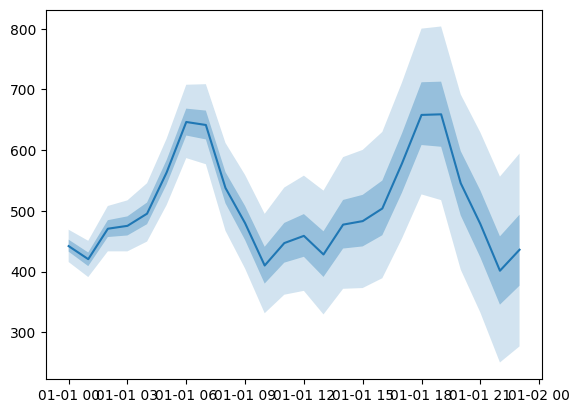

In [11]:
data = torch.tensor(np.genfromtxt(Path.cwd() / "air_passengers.csv"))  # Load Example

# Default: 2D Torch tensor
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="torch")
print("Predictions:\n", type(quantiles), quantiles.shape)


# 2D Numpy Array
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="numpy")
print("Predictions:\n", type(quantiles), quantiles.shape)


# Iterate by patch
# You can also use the forecast function as iterable. This might help with big datasets. All output_types are supported
for i, fc_batch in enumerate(
    model.forecast(context=[data, data, data, data, data], batch_size=2, output_type="torch", yield_per_batch=True)
):
    quantiles, means = fc_batch
    print(f"Predictions batch {i}:\n", type(quantiles), quantiles.shape)


try:
    # QuantileForecast (GluonTS)
    predictions_gluonts = model.forecast(context=data, prediction_length=24, output_type="gluonts")
    print("Predictions (GluonTS Quantile Forecast):\n", type(predictions_gluon), type(predictions_gluon[0]))
    predictions_gluonts[0].plot()
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]